# UR Desa Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor True crop, input tingkat desa.

### Import Fast Ai

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [2]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
from sklearn.model_selection import StratifiedKFold

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/IDM/02. Desa Sentinel 10m ES.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [8]:
def plot_multroc(tst_preds, k =5):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots( figsize=(9,7))
    for i in range(0,k):
        fpr, tpr, thresholds = metrics.roc_curve(tst_preds[i][1], tst_preds[i][0][:,1])
        roc_auc = metrics.auc(fpr, tpr)
        viz = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name="ROC fold {}".format(i))
        viz.plot(ax = ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.35,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")

    plt.show()

Buka data variabel

### Run Dataset

Preprocessing penyiapan data citra untuk diload perbatch ke fast ai.

In [15]:
path = Path.cwd() / ("02. Desa Sentinel 10m ES")

In [ ]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('rural'),Path('urban'),Path('models')]

In [ ]:
fname = (path/"rural").ls()[0]
fname

Path('rural/3208050012.jpg')

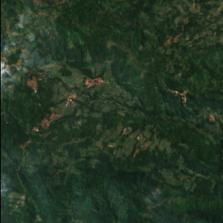

In [ ]:
img = Image.open(fname)
img

Pembentukan data block

In [16]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

Load dan print conto batch

In [17]:
dls = blocks.dataloaders(path)

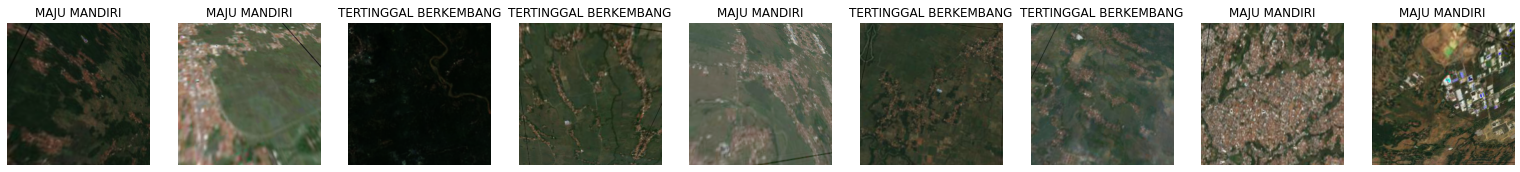

In [18]:
dls.show_batch(nrows=1)

In [13]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metricsc=[accuracy,bc, Precision(), Recall(),Recall(pos_label=0), f1s, roca]


Mencari batas maksimum untuk learning rate

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

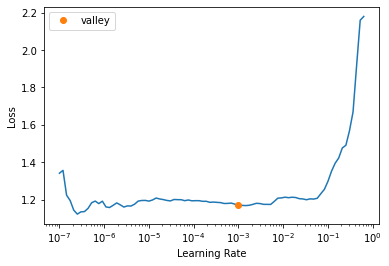

In [19]:
learn = vision_learner(dls, densenet121, metrics=metrics) 
learn.lr_find()

Smith fit one cycle terhadap densenet

In [21]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items
import random
random.shuffle(train_imgs)
item_tfms = [ToTensor(),]
batch_tfms = [IntToFloatTensor(),]


In [22]:
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn = vision_learner(dls, densenet121, metrics=metricsc) 
    learn.fit_one_cycle(4,1e-2)
    val_pct.append(learn.validate())
    tst_preds.append(learn.get_preds(ds_idx=1))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,1.038131,0.712691,0.603951,0.615125,0.758945,0.579023,0.651226,0.594294,0.659743,00:26
1,0.855784,0.713236,0.659454,0.526776,0.667671,0.955460,0.098093,0.475975,0.577281,00:25
2,0.770851,0.783719,0.703669,0.623653,0.724911,0.882184,0.365123,0.627772,0.705444,00:25
3,0.593149,0.664052,0.701787,0.626081,0.727491,0.870690,0.381471,0.630843,0.707233,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.967386,1.004105,0.477893,0.542771,0.704545,0.280543,0.805000,0.469204,0.559152,00:25
1,0.822070,0.753786,0.602070,0.616039,0.739044,0.559578,0.672500,0.598372,0.659879,00:25
2,0.661526,0.692014,0.647225,0.602653,0.692000,0.782805,0.422500,0.604330,0.680115,00:25
3,0.507169,0.663983,0.681091,0.628810,0.705063,0.840121,0.417500,0.631487,0.710415,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.986428,0.860137,0.505650,0.546458,0.707921,0.412698,0.680217,0.505112,0.575210,00:27
1,0.794823,0.857095,0.539548,0.585735,0.756281,0.434343,0.737127,0.539204,0.628226,00:25
2,0.650777,0.600603,0.713748,0.647626,0.740420,0.864358,0.430894,0.654429,0.720918,00:25
3,0.486919,0.610862,0.696799,0.638440,0.738126,0.829726,0.447154,0.643692,0.716745,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,1.031718,1.031934,0.473635,0.552082,0.743590,0.293353,0.810811,0.469207,0.587623,00:26
1,0.768368,0.841097,0.615819,0.537939,0.674020,0.794798,0.281081,0.533553,0.614259,00:25
2,0.667748,0.640579,0.637476,0.621212,0.744817,0.674855,0.567568,0.614926,0.681995,00:25
3,0.492990,0.618391,0.701507,0.642048,0.738854,0.838150,0.445946,0.647711,0.728035,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.969497,0.671701,0.670433,0.586385,0.675526,0.914543,0.258228,0.572651,0.640723,00:25
1,0.812827,1.339577,0.645009,0.651834,0.766544,0.625187,0.678481,0.637881,0.695808,00:25
2,0.690624,0.722250,0.685499,0.656193,0.739568,0.770615,0.541772,0.658226,0.716061,00:25
3,0.562894,0.595457,0.709040,0.661513,0.731865,0.847076,0.475949,0.667086,0.740884,00:25


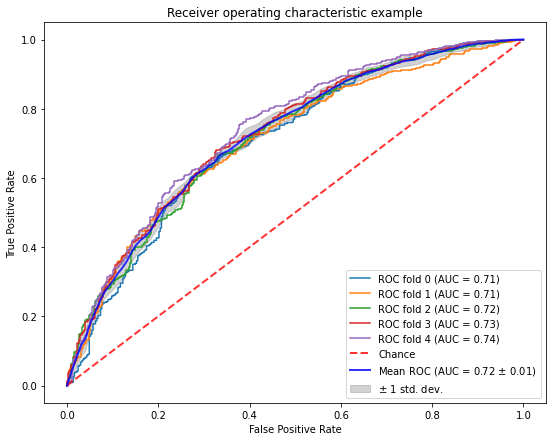

In [23]:
plot_multroc(tst_preds, k = 5)

In [24]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/02. densenet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)

In [25]:
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/02. densenet.csv")

Pemodelan densenet dengan metrik bersesuaian

In [26]:
pd.DataFrame(val_pct).mean()

0    0.630549
1    0.698045
2    0.639378
3    0.728280
4    0.845153
5    0.433604
6    0.644164
7    0.720662
dtype: float64

### Resnet

Pembentukan model semisal untuk resnet

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.009120108559727669)

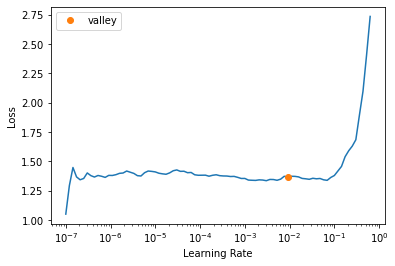

In [27]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 
learn_rs.lr_find()

In [28]:
val_pct_rs = []
tst_preds_rs = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn_rs = vision_learner(dls, resnet50, metrics=metricsc) 
    learn_rs.fit_one_cycle(3,1e-2)
    val_pct_rs.append(learn_rs.validate())
    tst_preds_rs.append(learn_rs.get_preds(ds_idx=1))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,1.034446,0.874187,0.571966,0.575887,0.721915,0.563218,0.588556,0.559902,0.622350,00:23
1,0.791846,0.623535,0.664158,0.611513,0.726302,0.781609,0.441417,0.614356,0.664427,00:22
2,0.629496,0.608877,0.699906,0.625932,0.727932,0.864943,0.386921,0.630762,0.710040,00:22


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.958757,0.850578,0.633114,0.594811,0.689320,0.749623,0.440000,0.596301,0.631938,00:22
1,0.760585,0.704060,0.655691,0.615390,0.702041,0.778281,0.452500,0.617725,0.676331,00:22
2,0.595534,0.666534,0.687676,0.648965,0.724559,0.805430,0.492500,0.652778,0.698771,00:22


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,1.061780,0.842896,0.593220,0.607222,0.752418,0.561328,0.653117,0.585164,0.635730,00:22
1,0.775392,0.663608,0.664783,0.585401,0.701796,0.845599,0.325203,0.584850,0.639140,00:22
2,0.604317,0.611229,0.668550,0.622497,0.733242,0.773449,0.471545,0.624976,0.712585,00:22


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.984728,0.851027,0.645951,0.589357,0.708443,0.776012,0.402703,0.591413,0.650121,00:22
1,0.756487,0.854393,0.647834,0.607151,0.724576,0.741329,0.472973,0.608141,0.671294,00:22
2,0.631752,0.618543,0.675141,0.615529,0.723295,0.812139,0.418919,0.619214,0.707393,00:22


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.971235,0.819204,0.634652,0.617778,0.720379,0.683658,0.551899,0.615332,0.653802,00:22
1,0.794359,0.810884,0.670433,0.619938,0.705045,0.817091,0.422785,0.622624,0.682652,00:22
2,0.655457,0.608484,0.711864,0.662729,0.731707,0.854573,0.470886,0.668527,0.733604,00:22


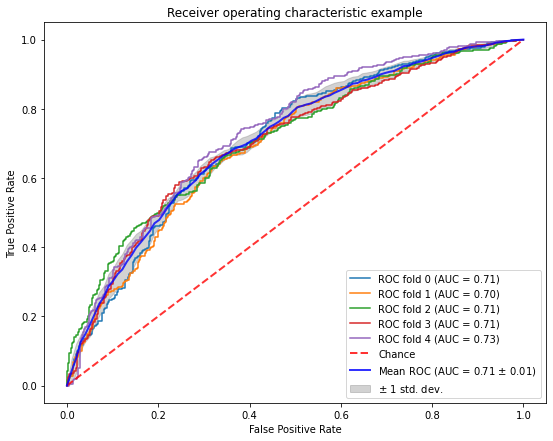

In [29]:
plot_multroc(tst_preds_rs, k = 5)

In [30]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/02. resnet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds_rs, fp)

In [31]:
pd.DataFrame(val_pct_rs).mean()

0    0.622733
1    0.688628
2    0.635130
3    0.728147
4    0.822107
5    0.448154
6    0.639252
7    0.712479
dtype: float64

In [32]:
pd.DataFrame(val_pct_rs).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/02. resnet.csv")